In [1]:
# import autosklearn.classification
from pipeline import *

# pipeline_year(10)

df_coaches = pd.read_csv('dataset/cleaned/coaches.csv')
models = [
    lambda: RandomForestClassifier(n_estimators=100, random_state=42),
    #lambda: LogisticRegression(max_iter=1000, random_state=42),
    lambda: SVC(C=1.0, kernel='rbf', probability=True),
    lambda: GaussianNB(),
    lambda: KNeighborsClassifier(n_neighbors=5),
    lambda: DecisionTreeClassifier(max_depth=5, random_state=42),
    lambda: GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    lambda: MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
]

def run_window_decay(model, year):
    l = []

    # param_grids = [
    #     {
    #         'n_estimators': [100, 200, 300],
    #         'max_depth': [5, 10, None],
    #         'min_samples_split': [2, 5, 10],
    #         'random_state': [42]
    #     },
    #     {
    #         'C': [1.0, 0.1, 0.01],
    #         'kernel': ['rbf', 'linear'],
    #         'probability': [True]
    #     },
    #     {},
    #     {
    #         'n_neighbors': [5, 10, 15],
    #         'weights': ['uniform', 'distance']
    #     },
    #     {
    #         'max_depth': [5, 10, 15],
    #         'min_samples_split': [2, 5, 10],
    #         'random_state': [42]
    #     },
    #     {
    #         'n_estimators': [100, 200, 300],
    #         'learning_rate': [0.1, 0.01, 0.001],
    #         'max_depth': [3, 5, 7],
    #         'random_state': [42]
    #     },
    #     {
    #         'hidden_layer_sizes': [(100, 50), (200, 100), (300, 150)],
    #         'max_iter': [1000, 2000, 3000],
    #         'random_state': [42]
    #     }
    #     ]

    clf = model()
    decay_rate=2.5
    df_teams_merged = []
    test = []
    train = []
    for i in range(2, year + 1):
        df_teams_merged = pipeline_clf(year=i)
        weight = decay_rate ** (10 - i - 1)

        df_teams_merged['confID'] = df_teams_merged['confID'].replace({'EA': 0, 'WE': 1})

        train = df_teams_merged[df_teams_merged['year'] < i]
        test = df_teams_merged[df_teams_merged['year'] == i]

        #if (year == i):
        #    break


        X_train = train[train.drop(['playoff', 'year', 'tmID'], axis=1).columns]
        y_train = train['playoff']
        sample_weight = [weight] * len(X_train)

        # grid_search_results = []
        # best_model = None
        # best_score = 0

        # # Perform grid search for each model
        # for model, param_grid in zip(models, param_grids):
        #     grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        #     grid_search.fit(train.drop(['playoff', 'year', 'tmID'], axis=1), train['playoff'])  # Replace X and y with your data
        #     grid_search_results.append(grid_search)
        #     if grid_search.best_score_ > best_score:
        #         best_score = grid_search.best_score_
        #         best_model = grid_search.best_estimator_

        # for model, grid_search_result in zip(models, grid_search_results):
        #     print(f"Best parameters for {model.__class__.__name__}: {grid_search_result.best_params_}")
        #     print(f"Best score for {model.__class__.__name__}: {grid_search_result.best_score_}")

        # clf = best_model

        if type(model()).__name__ in ["KNeighborsClassifier", "MLPClassifier"]:
            clf.fit(X_train, y_train)  # This model don't support sample weights
        else:
            clf.fit(X_train, y_train, sample_weight=sample_weight)

    predictions = clf.predict_proba(test.drop(['playoff', 'year', 'tmID'], axis=1))[:, 1]
    test['predictions'] = predictions
    df_teams_merged['predictions'] = 0
    df_teams_merged.loc[df_teams_merged['year'] == year, 'predictions'] = predictions

    df_teams_merged['confID'] = df_teams_merged['confID'].replace({0: 'EA', 1 : 'WE'})

    # print the year and the predicted scores
    # print(df_teams_merged[df_teams_merged['year'] == year][['tmID', 'confID', 'predictions', 'awards', 'offensive_strength']].sort_values(by='predictions', ascending=False))


    df_teams, ea_teams, we_teams = classify_playoff_entry(
            df_teams_merged, year)

    ea_predictions = ea_teams['tmID'].unique()
    we_predictions = we_teams['tmID'].unique()


    accuracy = calculate_playoff_accuracy(
        year, ea_predictions, we_predictions, display_results = False)

    return accuracy


In [2]:
pipeline_year(8,display_results=True)



Year:               8
WE
Guesses:       SEA, PHO, LAS, HOU
Missed:        SAC, SAS
EA
Guesses:       CON, DET, IND, WAS
Missed:        NYL
Total accuracy:     62.50%



62.5

c:\Users\ricar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ricar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ricar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ricar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the opti

[[62.5, 50.0, 75.0, 75.0, 75.0, 100.0, 62.5, 87.5, 87.5], [50.0, 50.0, 75.0, 62.5, 75.0, 100.0, 62.5, 62.5, 87.5], [62.5, 50.0, 62.5, 75.0, 75.0, 87.5, 62.5, 62.5, 87.5], [50.0, 50.0, 75.0, 62.5, 62.5, 100.0, 62.5, 62.5, 75.0], [62.5, 62.5, 62.5, 62.5, 75.0, 50.0, 62.5, 50.0, 87.5], [50.0, 50.0, 75.0, 75.0, 75.0, 100.0, 62.5, 62.5, 87.5], [50.0, 50.0, 62.5, 62.5, 75.0, 87.5, 62.5, 62.5, 75.0]]


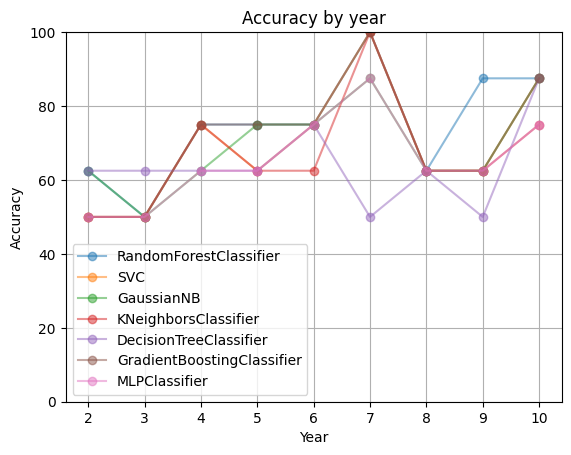

In [3]:
from pipeline import *

def check_accuracy_by_year2(models):
    # Create a list to store accuracy values for each model
    accs = []
    
    # Define the years
    years = list(range(2, 11))
    
    # Calculate accuracy for each year for each model
    for model in models:
        model_accs = [run_window_decay(model, year) for year in years]
        accs.append(model_accs)
    #accs = [[75.0, 50.0, 75.0, 75.0, 87.5, 87.5, 62.5, 87.5, 87.5], [50.0, 50.0, 87.5, 50.0, 62.5, 25.0, 62.5, 62.5, 75.0], [62.5, 50.0, 62.5, 75.0, 75.0, 87.5, 62.5, 75.0, 87.5], [50.0, 50.0, 62.5, 62.5, 62.5, 87.5, 62.5, 62.5, 75.0], [62.5, 50.0, 87.5, 62.5, 75.0, 75.0, 62.5, 50.0, 75.0], [50.0, 50.0, 50.0, 87.5, 75.0, 87.5, 62.5, 62.5, 87.5], [62.5, 50.0, 50.0, 75.0, 75.0, 100.0, 62.5, 87.5, 75.0]]
    print(accs)

    # Plot the accuracy line graphs for each model
    for i, model_acc in enumerate(accs):
        plt.plot(years, model_acc, label=f"{type(models[i]()).__name__ }", marker='o', linestyle='-', alpha=0.5)

    # Add labels for each data point
    # for i, model_acc in enumerate(accs):
    #     for j, acc in enumerate(model_acc):
    #         plt.text(years[j], acc, f"{acc:.2f}", ha="center", va="bottom")

    # Add legend
    plt.legend()

    # Set Y-axis limits
    plt.ylim(0, 100)

    plt.xlabel("Year")
    plt.ylabel("Accuracy")
    plt.title("Accuracy by year")
    plt.grid(True)

    plt.show()

check_accuracy_by_year2(models)


In [4]:
run_window_decay(models[0], 10)

87.5